# Task 2: Classifiers on Supermarket Sales

In [4]:
import numpy as np
import pandas as pd
import time
from tabulate import tabulate
import psutil
import os

In [5]:
csv_file_path = "C:\\Users\\AMAN\Desktop\\DMML Assignments\\Assignment 1 by Aman and Salokya Deb\\Task-2\\supermarket-sales-data.csv"

data = pd.read_csv(csv_file_path)

In [6]:
# Checking for missing values and data types
missing_values = data.isnull().sum()
data_types = data.dtypes

info_table = pd.DataFrame({'Missing Values': missing_values, 'Data Types': data_types})
info_table = info_table.apply(lambda x: x.astype(str).str.center(15))
info_table.columns = info_table.columns.str.center(15)

print(info_table)

               Missing Values     Data Types  
InvoiceID            0              object    
Branch               0              object    
CustomerType         0              object    
Gender               0              object    
ProductType          0              object    
UnitPrice            0             float64    
Quantity             0              int64     
Tax                  0             float64    
Total                0             float64    
PaymentType          0              object    
Rating               0             float64    


In [7]:
# InvoiceID is not needed for classification
data = data.drop(data.columns[0], axis=1)

In [8]:
# For Decision Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# For Random Forest
from sklearn.ensemble import RandomForestClassifier

# For Linear Regression
from sklearn.linear_model import LinearRegression

# Import module for trining and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# For categorical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler

# Import module for handling column transformations in the machine learning pipeline
from sklearn.compose import ColumnTransformer

# Import necessary modules for creating a machine learning pipeline
from sklearn.pipeline import Pipeline

# Import scikit-learn metrics module for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

## Gender prediction 

In [9]:
start = time.time()
# Define a lambda function for Winsorization
winsorize_lambda = lambda x: x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95))

# Apply Winsorization to handle outliers in numerical columns
numerical_columns = ['UnitPrice', 'Quantity', 'Tax', 'Total', 'Rating']
data[numerical_columns] = data[numerical_columns].apply(winsorize_lambda)

# Separate features and target variable
X = data.drop('Gender', axis=1) # Features
y = data['Gender'] # Target Variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a ColumnTransformer for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object', 'bool']).columns)
    ],
    remainder='passthrough'
)
end = time.time()
preprocessing_time = end-start

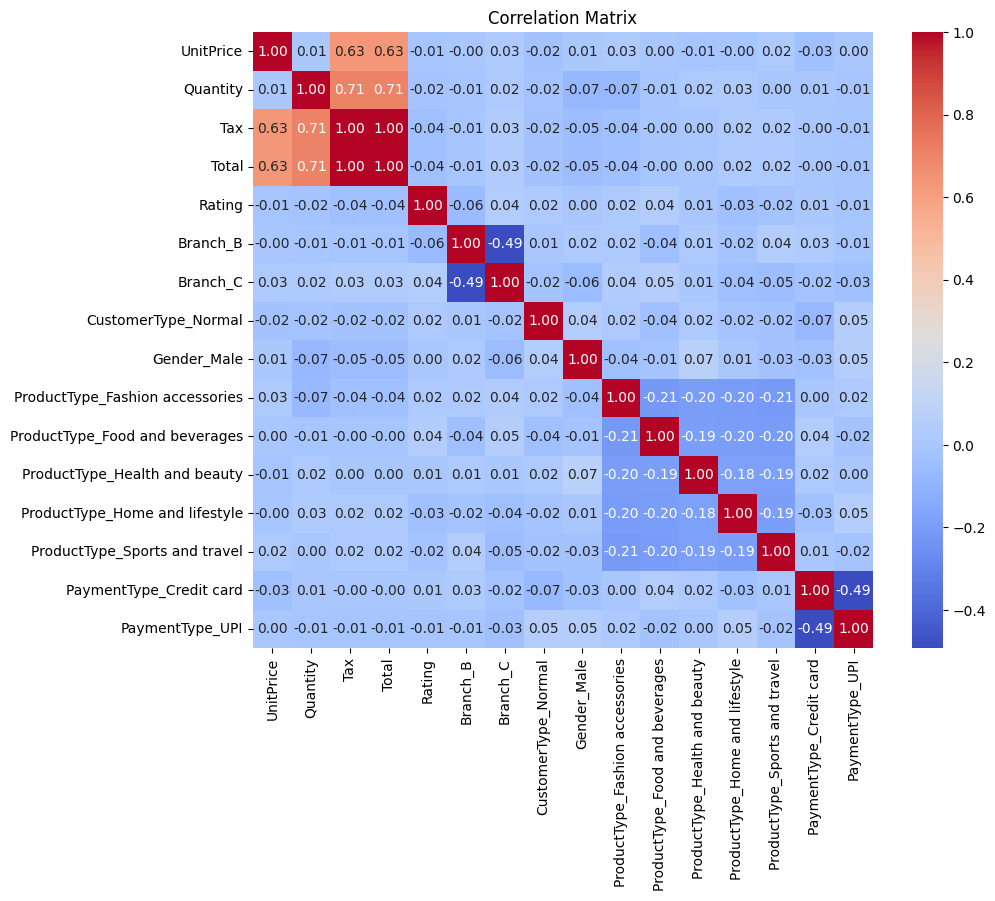

In [10]:
# Assuming data contains the dataset with numerical and categorical columns
numerical_data = data[numerical_columns]
categorical_data = data.select_dtypes(include=['object', 'bool'])

# One-hot encode categorical columns using pandas get_dummies function
encoded_categorical_data = pd.get_dummies(categorical_data, drop_first=True)

# Concatenate numerical and encoded categorical data
combined_data = pd.concat([numerical_data, encoded_categorical_data], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Using Decision Tree

In [17]:
start = time.time()
# Create a pipeline with the ColumnTransformer and DecisionTreeClassifier
pipeline_DT = Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])

# Dictionary specifying the hyperparameter values to search over during Grid Search
param_grid_DT = {
    'classifier__max_depth': [None, 5, 10, 15],  # The maximum depth of the decision tree
    'classifier__min_samples_split': [2, 5, 10], # This parameter controls the minimum size of a node before a split is considered
    'classifier__min_samples_leaf': [1, 2, 4],    # The minimum number of samples required to be at a leaf node
    'classifier__criterion': ['gini', 'entropy'],    # The function used to measure the quality of a split
    'classifier__splitter': ['best', 'random']       # 'best' chooses the best split, and 'random' chooses the best random split.
}

# Perform grid search with cross-validation
grid_search_DT = GridSearchCV(pipeline_DT, param_grid_DT,
                            cv = 5,                # The model is trained and evaluated five times, each time using a different fold as the test set
                            scoring = 'accuracy',  # Parameter to evaluate performance of model 
                            n_jobs = -1            # Setting it to -1 means that the computation will be performed using all available CPUs
                            )

# Get the initial memory usage
process = psutil.Process(os.getpid())
memory_beforeD = process.memory_info().rss

# Fit the grid search to the data
grid_search_DT.fit(X_train, y_train)

# Get the memory usage after fitting
memory_afterD = process.memory_info().rss

# Calculate the memory consumed
memory_consumed_DT = (memory_afterD - memory_beforeD) / 1024

# Get the best model from grid search
best_model_DT = grid_search_DT.best_estimator_

# Best parameters and best score
print("Best parameters found: ", best_model_DT)

# Make predictions on the test set
y_pred_DT = best_model_DT.predict(X_test)
end = time.time()

# Predictions on training data
y_train_pred_DT = best_model_DT.predict(X_train)

run_time_dt = (end-start)+preprocessing_time

Best parameters found:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Branch', 'CustomerType', 'ProductType', 'PaymentType'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_split=10,
                                        random_state=42))])


#### Evaluation Metrics

In [18]:
# Evaluating the model
print("Best Model Parameters:", grid_search_DT.best_params_)
accuracy_train_DT = accuracy_score(y_train, y_train_pred_DT)
accuracy_DT = accuracy_score(y_test, y_pred_DT)
precision_DT = precision_score(y_test, y_pred_DT, pos_label='Female')
recall_DT = recall_score(y_test, y_pred_DT, pos_label='Female')
f1score_DT = f1_score(y_test, y_pred_DT, pos_label='Female')
print(f'Training Data Accuracy Score: {accuracy_train_DT:.2f}')
print(f'Test Data Accuracy Score: {accuracy_DT:.2f}')
print(f'Test Data Precision Score: {precision_DT:.2f}')
print(f'Test Data Recall Score: {recall_DT:.2f}')
print(f'Test Data F1 Score: {f1score_DT:.2f}')

# Confusion matrix
conf_matrix_DT = confusion_matrix(y_test, y_pred_DT)

print('\nConfusion Matrix:')
print(conf_matrix_DT)

Best Model Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__splitter': 'best'}
Training Data Accuracy Score: 0.88
Test Data Accuracy Score: 0.50
Test Data Precision Score: 0.46
Test Data Recall Score: 0.55
Test Data F1 Score: 0.50

Confusion Matrix:
[[75 61]
 [89 75]]


### Using Random Forest

In [19]:
start=time.time()

# Create a pipeline with the ColumnTransformer and RandomForestClassifier
pipeline_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Dictionary specifying the hyperparameter values to search over during Grid Search
param_grid_RF = {
    'classifier__n_estimators': [50, 100, 150],        # Number of trees in the forest
    'classifier__max_depth': [None, 5, 10],           # Maximum Depth of each tree to control overfitting
    'classifier__min_samples_split': [2, 5, 10],       # This parameter controls the minimum size of a node before a split is considered
    'classifier__min_samples_leaf': [1, 2, 4],         # This parameter controls the minimum size of a leaf node
    'classifier__criterion': ['gini', 'entropy'],      # The function used to measure quality of a split
    'classifier__max_features': ['sqrt', 'log2'] # The number of features to consider when looking for the best split
}

# Perform grid search with cross-validation
grid_search_RF = GridSearchCV(pipeline_RF, param_grid_RF, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1)

# Get the initial memory usage
process = psutil.Process(os.getpid())
memory_beforeR = process.memory_info().rss

grid_search_RF.fit(X_train, y_train)

# Get the memory usage after fitting
memory_afterR = process.memory_info().rss

# Calculate the memory consumed
memory_consumed_RF = (memory_afterR - memory_beforeR) / 1024

# Get the best model from grid search
best_model_RF = grid_search_RF.best_estimator_

# Best parameters and best score
print("Best parameters found: ", best_model_RF)

# Make predictions on the test set
y_pred_RF = best_model_RF.predict(X_test)
end = time.time()

# Predictions on training data
y_train_pred_RF = best_model_RF.predict(X_train)

run_time_rf = (end-start)+preprocessing_time

Best parameters found:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Branch', 'CustomerType', 'ProductType', 'PaymentType'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])


#### Evaluation Metrics

In [20]:
# Evaluating the model
print("Best Model Parameters:", grid_search_RF.best_params_)
accuracy_train_RF = accuracy_score(y_train,y_train_pred_RF)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
precision_RF = precision_score(y_test, y_pred_RF, pos_label='Female')
recall_RF = recall_score(y_test, y_pred_RF, pos_label='Female')
f1score_RF = f1_score(y_test, y_pred_RF, pos_label='Female')
print(f'Training Data Accuracy Score: {accuracy_train_RF:.2f}')
print(f'Test Data Accuracy Score: {accuracy_RF:.2f}')
print(f'Test Data Precision Score: {precision_RF:.2f}')
print(f'Test Data Recall Score: {recall_RF:.2f}')
print(f'Test Data F1 Score: {f1score_RF:.2f}')

# Confusion matrix
conf_matrix_DT = confusion_matrix(y_test, y_pred_RF)

print('\nConfusion Matrix:')
print(conf_matrix_DT)

Best Model Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Training Data Accuracy Score: 0.81
Test Data Accuracy Score: 0.50
Test Data Precision Score: 0.47
Test Data Recall Score: 0.70
Test Data F1 Score: 0.56

Confusion Matrix:
[[ 95  41]
 [109  55]]


## Comparative Evaluation of Models for Gender Prediction

### Comparison of Performance Metrics

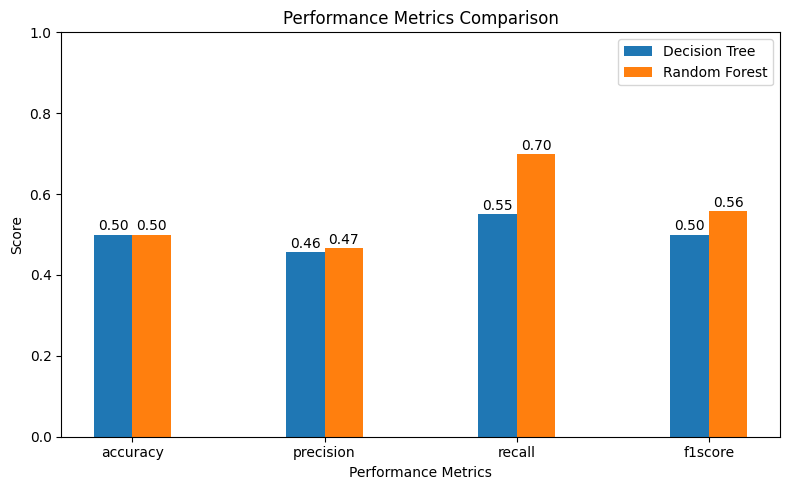

In [21]:
# Sample data for three models
Performance_Metrics = ['accuracy', 'precision', 'recall', 'f1score']

Decision_Tree = [accuracy_DT, precision_DT,recall_DT, f1score_DT]
Random_Forest = [accuracy_RF, precision_RF, recall_RF, f1score_RF]


# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the X-axis
index = np.arange(len(Performance_Metrics))

# Plotting the bars
plt.figure(figsize=(8, 5))  # Set the size of the plot
plt.bar(index - 0.5*bar_width, Decision_Tree, bar_width, label='Decision Tree')
plt.bar(index + 0.5*bar_width, Random_Forest, bar_width, label='Random Forest')

# Displaying the values on the bars
for i in range(len(Performance_Metrics)):
    plt.text(index[i] - 0.5*bar_width, Decision_Tree[i] + 0.01, f'{Decision_Tree[i]:.2f}', ha='center')
    plt.text(index[i] + 0.5*bar_width, Random_Forest[i] + 0.01, f'{Random_Forest[i]:.2f}', ha='center')

# Customizing the plot
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(index, Performance_Metrics)
plt.legend()

# Setting y-limit
plt.ylim(0, 1)

# Displaying the plot
plt.tight_layout()
plt.show()

### Comparison of Run Times and Memory Used

In [30]:
metrics = {
    'Model Type': ['Decision Tree Classifier','Random Forest Classifier'],
    'Run Time': [run_time_dt, run_time_rf],
    'Memory Used (in KB)': [memory_consumed_DT, memory_consumed_RF]
}

metrics_df = pd.DataFrame(metrics)

table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

print(table)


+--------------------------+-------------------+---------------------+
|        Model Type        |     Run Time      | Memory Used (in KB) |
+--------------------------+-------------------+---------------------+
| Decision Tree Classifier | 2.697687864303589 |       2048.0        |
| Random Forest Classifier | 38.57482147216797 |        384.0        |
+--------------------------+-------------------+---------------------+


## Rating prediction 

In [31]:
# Define a lambda function for Winsorization
winsorize_lambda = lambda x: x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95))

# Apply Winsorization to handle outliers in numerical columns
numerical_columns = ['UnitPrice', 'Quantity', 'Tax', 'Total']
data[numerical_columns] = data[numerical_columns].apply(winsorize_lambda)

# Encode categorical string columns using one-hot encoding
df = pd.get_dummies(data)

# Separate features and target variable
X = df.drop('Rating', axis=1)
y = df['Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define a ColumnTransformer for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object', 'bool']).columns)
    ],
    remainder='passthrough'
)

### Using Linear Regression

In [32]:
start = time.time()
# Get memory usage before creating and training the model
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss

# Create and train the linear regression model
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

# Make predictions on testing data
y_pred_LR = model_LR.predict(X_test)

# Get memory usage after creating and training the model
memory_after = process.memory_info().rss

# Calculate the memory used by the model
memory_used_lr = (memory_after - memory_before) / 1024

end = time.time()
run_time_lr = end-start

# Evaluate the model's performance
LR_mse = mean_squared_error(y_test, y_pred_LR)
LR_rmse = np.sqrt(LR_mse)
LR_mae = mean_absolute_error(y_test,y_pred_LR)
LR_r2 = r2_score(y_test,y_pred_LR)


### Using Decision Tree Regressor

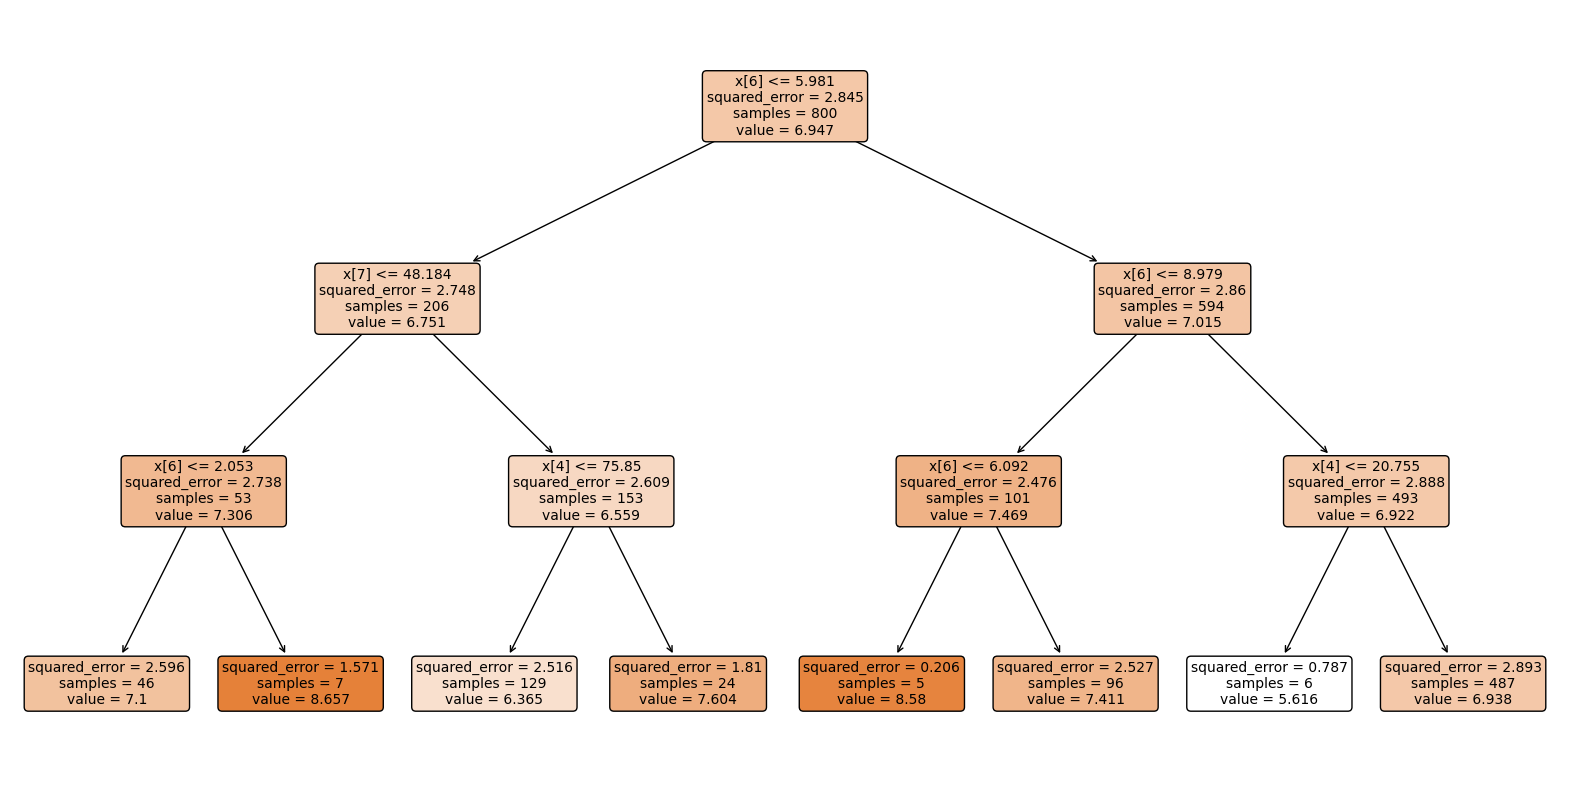

In [33]:
start = time.time()
# Identify the target variable and features
features = data.columns.drop('Rating')

# Check data types and handle categorical variables
label_encoders = {}
for column in features:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
        
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Get memory usage before executing the code
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss

# Perform grid search with cross-validation to find the best parameters
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Get memory usage after executing the code
memory_after = process.memory_info().rss

# Calculate the memory used by the code
memory_used_dtr = (memory_after - memory_before) / 1024 

end = time.time()
run_time_dtr = end-start

# Evaluating the model performance
DTR_mae = mean_absolute_error(y_test, predictions)
DTR_r2 = r2_score(y_test, predictions)
DTR_mse = mean_squared_error(y_test, predictions)
DTR_rmse = np.sqrt(DTR_mse)

# Visualizing the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, rounded=True, fontsize=10)
plt.show()

## Comparative Evaluation of Models for Rating Prediction

### Visual Inspection

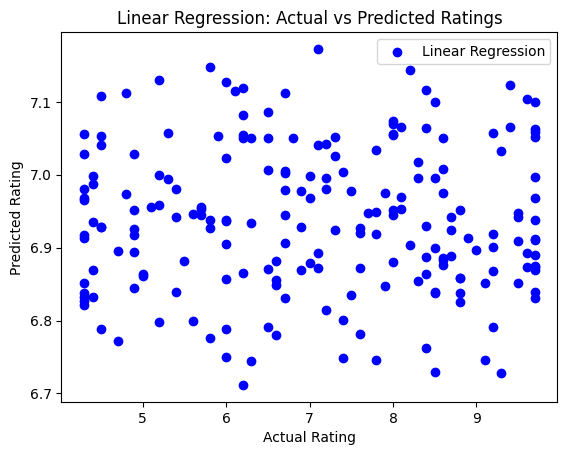

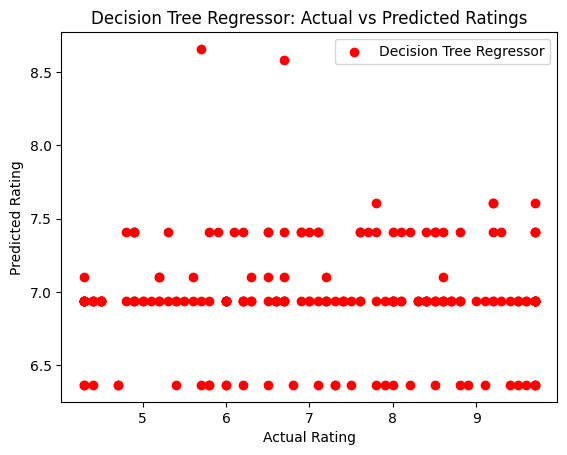

In [34]:
# Scatter plot for Linear Regression
plt.scatter(y_test, y_pred_LR, color='blue', label='Linear Regression')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Linear Regression: Actual vs Predicted Ratings')
plt.legend()
plt.show()

# Scatter plot for Decision Tree Regressor
plt.scatter(y_test, predictions, color='red', label='Decision Tree Regressor')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Decision Tree Regressor: Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [35]:
def adjusted_r_squared(y_true, y_pred, n, p):
    r_squared = r2_score(y_true, y_pred)
    return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

n_samples = len(y_test)
n_features = X_test.shape[1]

adj_r2_lr = adjusted_r_squared(y_test, y_pred_LR, n_samples, n_features)
adj_r2_dt = adjusted_r_squared(y_test, predictions, n_samples, n_features)

In [38]:
metrics_dict = {
    'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared (R2) Score', 'Adjusted R-squared'],
    'Linear Regression': [LR_mae, LR_mse, LR_rmse, LR_r2, adj_r2_lr],
    'Decision Tree Regressor': [DTR_mae, DTR_mse, DTR_rmse, DTR_r2, adj_r2_dt]
}

metrics_df = pd.DataFrame(metrics_dict)

table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

print(table)

+-------------------------+-----------------------+-------------------------+
|         Metric          |   Linear Regression   | Decision Tree Regressor |
+-------------------------+-----------------------+-------------------------+
|   Mean Absolute Error   |  1.4905714105140464   |   1.5087562351988524    |
|   Mean Squared Error    |  2.9684436212068688   |   3.0512232724812094    |
| Root Mean Squared Error |  1.7229171835021173   |   1.7467751064407833    |
|  R-squared (R2) Score   | -0.012743949082637318 |  -0.04098588379089185   |
|   Adjusted R-squared    | -0.06071603088128841  |  -0.09029574144414454   |
+-------------------------+-----------------------+-------------------------+


### Comparison of Run Times and Memory Used

In [37]:
metrics = {
    'Model Type': ['Linear Regression','Decision Tree Regressor'],
    'Run Time': [run_time_lr, run_time_dtr],
    'Memory Used (in KB)': [memory_used_lr, memory_used_dtr]
}

metrics_df = pd.DataFrame(metrics)

table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

print(table)

+-------------------------+----------------------+---------------------+
|       Model Type        |       Run Time       | Memory Used (in KB) |
+-------------------------+----------------------+---------------------+
|    Linear Regression    | 0.008046388626098633 |        12.0         |
| Decision Tree Regressor |  3.0651156902313232  |        60.0         |
+-------------------------+----------------------+---------------------+
